In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchmetrics import JaccardIndex
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import mtfsm as model
from acw_loss import ACW_loss
from dataset import FloorplanDataset

import os
import re


In [8]:

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Train

In [9]:
#Hyperparameters
alpha=0.7
lr=5e-4
weight_decay=2e-5
batch_size=10
num_epochs = 100
# scaler = GradScaler()  # For mixed precision
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Optional LR decay

In [10]:
#Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = model.get_model(pretrained_encoder=True, dropout=0.2)
net= net.to(device)

#optimizer
optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
#loss
wall_criterion=ACW_loss().to(device)
room_criterion=ACW_loss().to(device)

#Data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #for resnet pretrained
])

train_dataset= FloorplanDataset(dataset_dir="../train_data/mufp_10", split='train', transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_dataset= FloorplanDataset(dataset_dir="../train_data/mufp_10", split='test', transform=transform)
test_loader= DataLoader(test_dataset, batch_size=1, shuffle=False)

### Validation script

In [11]:
def validate_model(net, val_loader, wall_criterion, room_criterion, device, D=0.5):
    net.eval()
    val_loss = 0.0
    wall_iou_metric = JaccardIndex(task='multiclass', num_classes=4).to(device)
    room_iou_metric = JaccardIndex(task='multiclass', num_classes=7).to(device)
    wall_correct, wall_total = 0, 0
    room_correct, room_total = 0, 0

    with torch.no_grad():
        for images, wall_masks, room_masks in val_loader:
            images, wall_masks, room_masks = images.to(device), wall_masks.to(device), room_masks.to(device)
            wall_out, room_out, graph, room_loss = net(images)
            wall_loss = wall_criterion(wall_out, wall_masks)
            room_acw_loss = room_criterion(room_out, room_masks)
            room_net_loss = room_loss + room_acw_loss
            total_loss = D * room_net_loss + (1 - D) * wall_loss
            val_loss += total_loss.item()

            # Compute IoU
            wall_preds = wall_out.argmax(dim=1)
            room_preds = room_out.argmax(dim=1)
            wall_iou_metric.update(wall_preds, wall_masks)
            room_iou_metric.update(room_preds, room_masks)

            # Compute pixel accuracy
            wall_correct += (wall_preds == wall_masks).sum().item()
            wall_total += wall_masks.numel()
            room_correct += (room_preds == room_masks).sum().item()
            room_total += room_masks.numel()

    avg_val_loss = val_loss / len(val_loader)
    wall_iou = wall_iou_metric.compute().item()
    room_iou = room_iou_metric.compute().item()
    wall_accuracy = wall_correct / wall_total
    room_accuracy = room_correct / room_total

    net.train()  # Restore training mode
    return avg_val_loss, wall_iou, room_iou, wall_accuracy, room_accuracy

def check_val_perf(test_net, summary_writer=None, global_step=None, verbose=True):
    print("Validation performance")
    avg_val_loss, wall_iou, room_iou, wall_accuracy, room_accuracy=validate_model(test_net, test_loader, wall_criterion, room_criterion, device, D=0.5)

    if summary_writer and global_step:
        summary_writer.add_scalar('avg_val_loss', avg_val_loss, global_step)
        summary_writer.add_scalar("wall_iou:", wall_iou, global_step)
        summary_writer.add_scalar("room_iou:", room_iou, global_step)
        summary_writer.add_scalar("wall_accuracy:", wall_accuracy, global_step)
        summary_writer.add_scalar("room_accuracy:", room_accuracy, global_step)

    if verbose:
        print("avg_val_loss:", avg_val_loss)
        print("wall_iou:", wall_iou)
        print("room_iou:", room_iou)
        # print("wall_accuracy:", wall_accuracy)
        # print("room_accuracy:", room_accuracy)


## Train loop

In [12]:
#Train loop
writer = SummaryWriter()
writer.add_graph(net, train_dataset.__getitem__(0)[0].unsqueeze(0))
global_step = 0
losses=[]
steps=[]

net.train()

for epoch in range(num_epochs):
    running_loss=0.0
    last_loss=0.0
    epoch_step=0

    # for i, (images, wall_masks, room_masks) in enumerate(train_loader):
    for i, (images, wall_masks, room_masks) in enumerate(train_loader):
        images=images.to(device)
        wall_masks=wall_masks.to(device)
        room_masks=room_masks.to(device)
        #fw pass
        wall_out, room_out, graph_out, room_scg_loss=net(images)
        #loss
        wall_loss=wall_criterion(wall_out, wall_masks)
        room_loss=room_scg_loss+room_criterion(room_out, room_masks)
        loss=alpha*room_loss + (1-alpha)*wall_loss
        print(f'Step {i} losses:', 'wall:', wall_loss.item(),'room:', room_loss.item(),'total:', loss.item())

        #Visualization
        writer.add_scalar('Loss/train', loss.item(), global_step)
        # writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], global_step)
        losses.append(loss.item())
        steps.append(global_step)
        global_step += 1
        epoch_step += 1
        running_loss+= loss.item()
        last_loss= loss.item()
        
        #backward
        loss.backward()
        optimizer.step()

    
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/epoch_step:.4f} Last_Loss: {last_loss}')
    
    torch.save(net.state_dict(), f'checkpoints/trained_model_ep{epoch}.pth')
    if epoch%10==0:
        check_val_perf(net, summary_writer=writer, global_step=global_step)

writer.close()

torch.save(net.state_dict(), '../models/test_model.pth')
print("Complete - saved trained model")

Step 0 losses: wall: 2.4664320945739746 room: 6.905451774597168 total: 5.5737457275390625
Epoch [1/100] Loss: 5.5737 Last_Loss: 5.5737457275390625
Validation performance
avg_val_loss: 2.3760428428649902
wall_iou: 0.023186715319752693
room_iou: 0.09621526300907135
Step 0 losses: wall: 2.4117326736450195 room: 2.2004141807556152 total: 2.2638096809387207
Epoch [2/100] Loss: 2.2638 Last_Loss: 2.2638096809387207
Step 0 losses: wall: 2.370512008666992 room: 2.1245977878570557 total: 2.1983718872070312


KeyboardInterrupt: 

# Stats

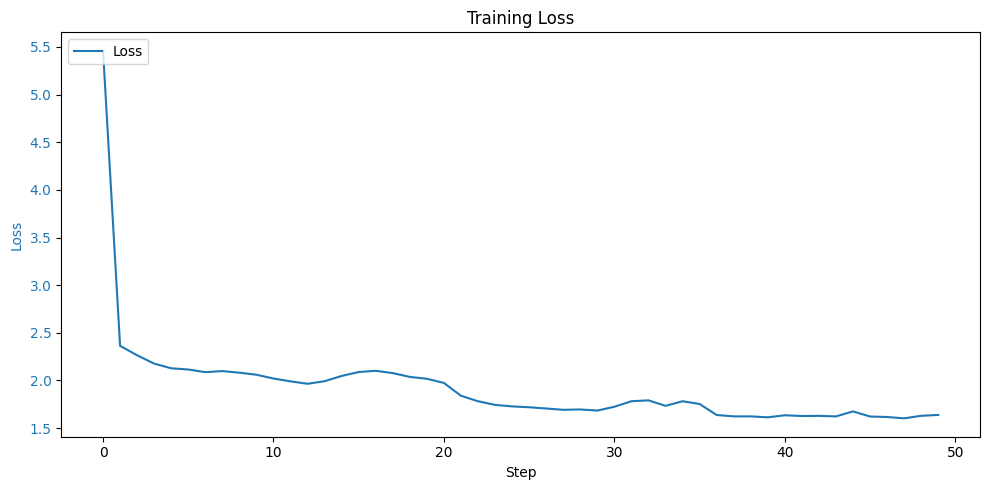

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot loss
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(steps, losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

plt.title('Training Loss')
fig.tight_layout()
plt.show()

# Tests

In [ ]:
def find_png_by_index(search_dir, index= 14):
    
    number = str(index)
    pattern = rf'r_{number}_([0-9a-f]{{40}})\.png'
    
    if not os.path.exists(search_dir):
        print(f"Directory '{search_dir}' not found.")
        return None
    
    for filename in os.listdir(search_dir):
        match = re.match(pattern, filename)
        if match:
            filename = f"r_{number}_{match.group(1)}.png"
            path = os.path.join(search_dir, filename)
            
            # Check if original file exists in floorplans/
            if os.path.exists(path):
                try:
                    img = Image.open(path)
                    return path
                except Exception as e:
                    print(f"Error displaying image: {e}")
                    return path
            else:
                print(f"Original file {filename} not found in '{search_dir}'.")
                return None
    
    print(f"No resized PNG file found for number {number} in '{search_dir}'.")
    return None

wall unique values before argmax [-47441336. -47413492. -47411016. ...  70654672.  70658112.  70699944.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


room [-2.1416314e+19 -2.1398588e+19 -2.1396199e+19 ...  1.1983200e+19
  1.1983705e+19  1.2000421e+19]
wall after argmax [0]
room [0 1 6]


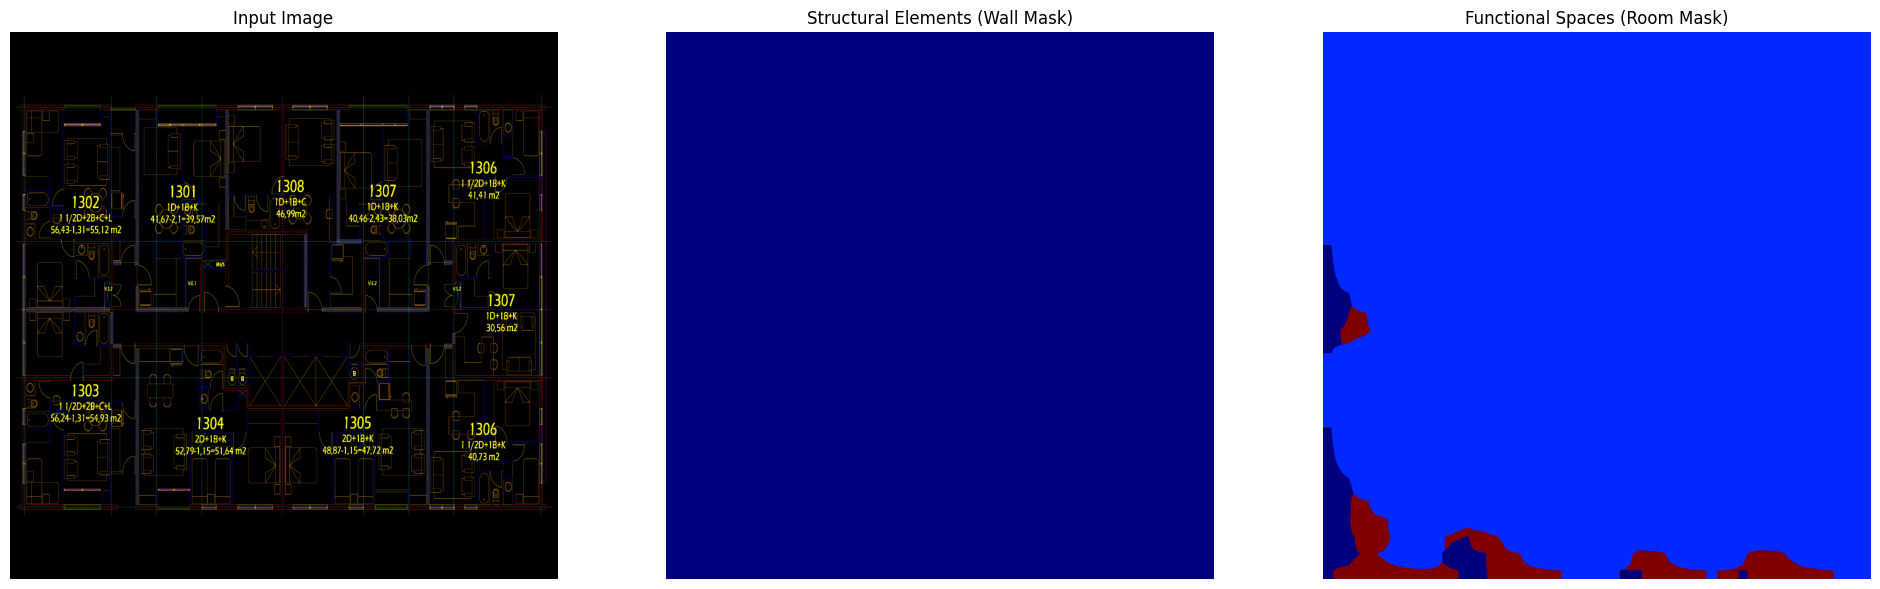

In [ ]:
net.eval()

test_epoch=33
test_image=20

net_checkpoint = torch.load(f'trained_model_ep{test_epoch}.pth', map_location=device)
net.load_state_dict(net_checkpoint)
net.eval()

input_image_path=find_png_by_index('../data/mufp_10/val/JPEGImages', index=test_image)
gt_path=find_png_by_index('../data/mufp_10/val/SegmentationClass', index=test_image)

input_image = Image.open(input_image_path).convert('RGB')
input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Shape: (1, 3, 1024, 1024)

with torch.no_grad():
    wall_pred, room_pred, graph, room_loss = net(input_image)

print("wall unique values before argmax", np.unique(wall_pred))
print("room", np.unique(room_pred))

wall_mask = torch.argmax(wall_pred, dim=1).squeeze(0)  # Shape: (1024, 1024)
room_mask = torch.argmax(room_pred, dim=1).squeeze(0)  

print("wall after argmax", np.unique(wall_mask))
print("room", np.unique(room_mask))

#ground truth
gt_mask= Image.open(gt_path).convert('RGB')
gt_mask_np=np.array(gt_mask)


fig, axes = plt.subplots(1, 3, figsize=(24, 8))

axes=axes.flatten()
show_image = input_image.permute(0, 2, 3, 1).squeeze(0).cpu().numpy()  # Shape: (1024, 1024, 3)
show_image=show_image* np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
axes[0].imshow(show_image)
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(wall_mask.cpu().numpy(), cmap='jet', vmin=0, vmax=3)  # Specify vmin/vmax for clarity
axes[1].set_title('Structural Elements (Wall Mask)')
axes[1].axis('off')

axes[2].imshow(room_mask.cpu().numpy(), cmap='jet', vmin=0, vmax=6)  # Specify vmin/vmax for 7 classes
axes[2].set_title('Functional Spaces (Room Mask)')
axes[2].axis('off')

# axes[3].imshow(Image.open(gt_path), cmap='jet')
# axes[3].set_title('Ground Truth')
# axes[3].axis('off')



plt.show()